<center><font size = "10"> Week 7 - Connections <center>
<center><font size = "8">Home work<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 1
<br>Group member1: Gasser Elbanna
<br>Group member2: Milo Imbeni
<br>Group member3: Louise Placidet

### From Homework 2: The morphologies we identified that did not have any errors are

### Cells: 3, 6, 7, 9, 10

# Ex1. Connect all-to-all with random weights.

<font size='3'>In week 2 Home Work (Morphologies) you've received a set of ten morphology files you were asked to check for quality. Each set of cells contains __FIVE__ good-quality morphology files you were asked to make note of and keep for future assignments. If you think that you only have three, please go through Week2_HomeWorks_Solutions.ipynb posted on Moodle to help you identify good morphologies for your group. For this exercise, connect your five cells all to all (unidirectionally) with uniform probability and display a connectivity matrix with weights and cell labels. (refer to tutorial 01 of this week for sample code). [1 pt]

In [1]:
# Importing usefull packages:
%matplotlib inline

from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np

### Step 1: Creating the Cell Class

In [4]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        h.load_file('import3d.hoc')
        h.load_file('stdlib.hoc')
        #morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self) # Notice this change to be able to instantiate several cells
    
    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
        
        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        if hasattr(self, 'apic'):
            for sec in self.apic:
                sec.insert('hh')
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        for sec in self.dend:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
                
        for sec in self.axon:
            sec.insert('hh')
            for seg in sec:    
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

### Step 2: Instanciate the Cells from Homework 2

In [5]:
Pyr1 = Cell('morph_06.swc','Pyr1','Pyr')
Pyr2 = Cell('morph_07.swc','Pyr2','Pyr')
Pyr3 = Cell('morph_09.swc','Pyr3','Pyr')
Int1 = Cell('morph_03.swc','Int1','Int')
Int2 = Cell('morph_10.swc','Int2','Int')

# Classing the cells by group:
cells_Pyr = [Pyr1, Pyr2, Pyr3]
cells_Int = [Int1, Int2]
cells = cells_Pyr + cells_Int

error morph_06.swc line 17828: could not parse: 
error morph_07.swc line 19678: could not parse: 
error morph_09.swc line 6173: could not parse: 
error morph_03.swc line 7281: could not parse: 
error morph_10.swc line 3377: could not parse: 


In [6]:
for c in cells_Pyr:
    print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon)))
for c in cells_Int:
    print('%s: %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.dend), len(c.soma), len(c.axon)))

Pyr1: 95 apical sections, 72 basal sections, 2 soma sections and 131 axon senctions
Pyr2: 131 apical sections, 82 basal sections, 2 soma sections and 125 axon senctions
Pyr3: 37 apical sections, 69 basal sections, 2 soma sections and 67 axon senctions
Int1: 45 basal sections, 2 soma sections and 103 axon senctions
Int2: 33 basal sections, 2 soma sections and 120 axon senctions


### Step 3: Connecting the Cells All-to-All with Random Weights

In [7]:
# returns NxN matrix of random weights in [0,1) with zero diagonal
def random_weights(n):
    rng = np.random.default_rng()
    weights = rng.random((n,n))
    np.fill_diagonal(weights,0.0)
    return weights

In [8]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(source, target, weight = None, delay = 5, source_sec = None, source_neurite = 'axon', target_sec = None, target_neurite = 'dend'):
    rng = np.random.default_rng()
    
    if weight is None:
        weight = rng.uniform() # random weight
    
    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0,len(target_neurite_)) # random dendritic section
    
    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0,len(source_neurite_)) # random axonal section
    
    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn) # store synapse
    
    netcon = h.NetCon(source_neurite_[source_sec](0.5)._ref_v, target_syn, sec=source_neurite_[source_sec])
    netcon.weight[0] = weight
    netcon.delay = delay
    
    print('Connected cells %s -> %s with weight %g and delay %g, from %s[%d] to %s[%d]' % (source.name,target.name,weight,delay,source_neurite,source_sec,target_neurite,target_sec))
    return netcon

In [10]:
weight_matrix = random_weights(5)

netcons = [] # save the netcons in case we want to modify them later

# Connect Pyr2, Pyr3, Int1 and Int2 to Pyr1
nc = connect(Pyr2,Pyr1,weight_matrix[0,1])
netcons.append(nc)
nc = connect(Pyr3,Pyr1,weight_matrix[0,2])
netcons.append(nc)
nc = connect(Int1,Pyr1,weight_matrix[0,3],target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr1,weight_matrix[0,4],target_neurite='soma')
netcons.append(nc)

# Connect Pyr1, Pyr3, Int1 and Int2 to Pyr2
nc = connect(Pyr1,Pyr2,weight_matrix[1,0])
netcons.append(nc)
nc = connect(Pyr3,Pyr2,weight_matrix[1,2])
netcons.append(nc)
nc = connect(Int1,Pyr2,weight_matrix[1,3],target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr2,weight_matrix[1,4],target_neurite='soma')
netcons.append(nc)

# Connect Pyr1, Pyr2, Int1 and Int2 to Pyr3
nc = connect(Pyr1,Pyr3,weight_matrix[2,0])
netcons.append(nc)
nc = connect(Pyr2,Pyr3,weight_matrix[2,1])
netcons.append(nc)
nc = connect(Int1,Pyr3,weight_matrix[2,3],target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr3,weight_matrix[2,4],target_neurite='soma')
netcons.append(nc)

# Connect Pyr1, Pyr2, Pyr3 and Int2 to Int1
nc = connect(Pyr1,Int1,weight_matrix[3,0])
netcons.append(nc)
nc = connect(Pyr2,Int1,weight_matrix[3,1])
netcons.append(nc)
nc = connect(Pyr3,Int1,weight_matrix[3,2])
netcons.append(nc)
nc = connect(Int2,Int1,weight_matrix[3,4],target_neurite='soma')
netcons.append(nc)
               
# Connect Pyr1, Pyr2, Pyr3 and Int1 to Int2
nc = connect(Pyr1,Int2,weight_matrix[4,0])
netcons.append(nc)
nc = connect(Pyr2,Int2,weight_matrix[4,1])
netcons.append(nc)
nc = connect(Pyr3,Int2,weight_matrix[4,2])
netcons.append(nc)
nc = connect(Int1,Int2,weight_matrix[4,3],target_neurite='soma')
netcons.append(nc)

Connected cells Pyr2 -> Pyr1 with weight 0.994253 and delay 5, from axon[46] to dend[47]
Connected cells Pyr3 -> Pyr1 with weight 0.575284 and delay 5, from axon[46] to dend[31]
Connected cells Int1 -> Pyr1 with weight 0.71154 and delay 5, from axon[75] to soma[1]
Connected cells Int2 -> Pyr1 with weight 0.496651 and delay 5, from axon[97] to soma[1]
Connected cells Pyr1 -> Pyr2 with weight 0.277002 and delay 5, from axon[42] to dend[12]
Connected cells Pyr3 -> Pyr2 with weight 0.370892 and delay 5, from axon[38] to dend[40]
Connected cells Int1 -> Pyr2 with weight 0.96336 and delay 5, from axon[97] to soma[1]
Connected cells Int2 -> Pyr2 with weight 0.496284 and delay 5, from axon[5] to soma[0]
Connected cells Pyr1 -> Pyr3 with weight 0.449776 and delay 5, from axon[80] to dend[5]
Connected cells Pyr2 -> Pyr3 with weight 0.539133 and delay 5, from axon[73] to dend[52]
Connected cells Int1 -> Pyr3 with weight 0.785511 and delay 5, from axon[19] to soma[1]
Connected cells Int2 -> Pyr3 w

### Step 4: Plotting the Weight Matrix with Weights and Cell Labels

In [24]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(5):
        for j in range(5):
            text = ax.text(j, i, "%.2f" %data[i, j],
                           ha="center", va="center", color="w")
    
    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title("Connectivity Matrix")
    
    
    return im, cbar

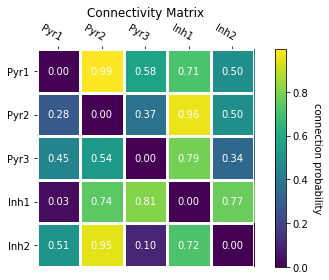

In [25]:
fig, ax = plt.subplots()

im, cbar = heatmap(weight_matrix, ['Pyr1', 'Pyr2', 'Pyr3', 'Inh1', 'Inh2'], ['Pyr1', 'Pyr2', 'Pyr3','Inh1', 'Inh2'], ax=ax, cmap="viridis", cbarlabel="connection probability")

fig.tight_layout()

# Ex2. Connect your cells considering connection probability

<font size='3'>Connect your five cells as it is done in tutorial 02, considering the following connection probabilities between cell types:
<br> PC - PC: 75 %
<br> PC - Inh: 19 %
<br> Inh - PC: 48 %
<br> Inh - Inh: 23 %

<font size='3'>Show the results on a probability matrix and the number of contacts each of your cells has. [1 pt]

<span style="color:red"> Restaring Kernel out of precaution...
    
    
### Step 1: Creating Cell Class

In [2]:
# Importing usefull packages:
%matplotlib inline

from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np

class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        h.load_file('import3d.hoc')
        h.load_file('stdlib.hoc')
        #morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self) # Notice this change to be able to instantiate several cells
    
    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
        
        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        if hasattr(self, 'apic'):
            for sec in self.apic:
                sec.insert('hh')
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        for sec in self.dend:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
                
        for sec in self.axon:
            sec.insert('hh')
            for seg in sec:    
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

### Step 2: Instanciate our Cells from Homework 2

In [3]:
Pyr1 = Cell('morph_06.swc','Pyr1','Pyr')
Pyr2 = Cell('morph_07.swc','Pyr2','Pyr')
Pyr3 = Cell('morph_09.swc','Pyr3','Pyr')
Int1 = Cell('morph_03.swc','Int1','Int')
Int2 = Cell('morph_10.swc','Int2','Int')

# Classing the cells by group:
cells_Pyr = [Pyr1, Pyr2, Pyr3]
cells_Int = [Int1, Int2]
cells = cells_Pyr + cells_Int

error morph_06.swc line 17828: could not parse: 
error morph_07.swc line 19678: could not parse: 
error morph_09.swc line 6173: could not parse: 
error morph_03.swc line 7281: could not parse: 
error morph_10.swc line 3377: could not parse: 


In [4]:
for c in cells_Pyr:
    print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon)))
for c in cells_Int:
    print('%s: %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.dend), len(c.soma), len(c.axon)))

Pyr1: 95 apical sections, 72 basal sections, 2 soma sections and 131 axon senctions
Pyr2: 131 apical sections, 82 basal sections, 2 soma sections and 125 axon senctions
Pyr3: 37 apical sections, 69 basal sections, 2 soma sections and 67 axon senctions
Int1: 45 basal sections, 2 soma sections and 103 axon senctions
Int2: 33 basal sections, 2 soma sections and 120 axon senctions


### Step 3: Connecting Cells based on Connection Probabilities

In [5]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(source, target, weight = None, delay = 5, source_sec = None, source_neurite = 'axon', target_sec = None, target_neurite = 'dend'):
    rng = np.random.default_rng()
    
    if weight is None:
        weight = rng.uniform() # random weight
    
    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0,len(target_neurite_)) # random dendritic section
    
    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0,len(source_neurite_)) # random axonal section
    
    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn) # store synapse
    
    netcon = h.NetCon(source_neurite_[source_sec](0.5)._ref_v, target_syn, sec=source_neurite_[source_sec])
    netcon.weight[0] = weight
    netcon.delay = delay
    
    print('Connected cells %s -> %s with weight %g and delay %g, from %s[%d] to %s[%d]' % (source.name,target.name,weight,delay,source_neurite,source_sec,target_neurite,target_sec))
    return netcon

In [6]:
# specify connection probabilites between cell types
conn_prob_matrix = np.zeros((2,2))
conn_prob_matrix[0,0] = 0.75 # Pyr to Pyr
conn_prob_matrix[0,1] = 0.19 # Pyr to Int
conn_prob_matrix[1,0] = 0.48 # Int to Pyr
conn_prob_matrix[1,1] = 0.23 # Int to Int

In [8]:
netcons = [] # store all netcons

rng = np.random.default_rng()

################ Pyramidal 1
# Connect Pyr2 to Pyr1
if rng.random() < conn_prob_matrix[0,0]:
    nc = connect(Pyr2, Pyr1)
    netcons.append(nc)
    
# Connect Pyr3 to Pyr1
if rng.random() < conn_prob_matrix[0,0]:
    nc = connect(Pyr3, Pyr1)
    netcons.append(nc)

# Connect Int1 to Pyr1
if rng.random() < conn_prob_matrix[1,0]:
    nc = connect(Int1, Pyr1, target_neurite='soma')
    netcons.append(nc)

# Connect Int2 to Pyr1
if rng.random() < conn_prob_matrix[1,0]:
    nc = connect(Int2, Pyr1, target_neurite='soma')
    netcons.append(nc)

################ Pyramidal 2
# Connect Pyr1 to Pyr2
if rng.random() < conn_prob_matrix[0,0]:
    nc = connect(Pyr2, Pyr2)
    netcons.append(nc)
    
# Connect Pyr3 to Pyr2
if rng.random() < conn_prob_matrix[0,0]:
    nc = connect(Pyr3, Pyr2)
    netcons.append(nc)

# Connect Int1 to Pyr2
if rng.random() < conn_prob_matrix[1,0]:
    nc = connect(Int1, Pyr2, target_neurite='soma')
    netcons.append(nc)

# Connect Int2 to Pyr2
if rng.random() < conn_prob_matrix[1,0]:
    nc = connect(Int2, Pyr2, target_neurite='soma')
    netcons.append(nc)

################ Pyramidal 3
# Connect Pyr1 to Pyr3
if rng.random() < conn_prob_matrix[0,0]:
    nc = connect(Pyr1, Pyr2)
    netcons.append(nc)
    
# Connect Pyr2 to Pyr3
if rng.random() < conn_prob_matrix[0,0]:
    nc = connect(Pyr2, Pyr3)
    netcons.append(nc)

# Connect Int1 to Pyr3
if rng.random() < conn_prob_matrix[1,0]:
    nc = connect(Int1, Pyr3, target_neurite='soma')
    netcons.append(nc)

# Connect Int2 to Pyr3
if rng.random() < conn_prob_matrix[1,0]:
    nc = connect(Int2, Pyr3, target_neurite='soma')
    netcons.append(nc)

################ Inhibitory 1
# Connect Pyr1 to Int1
if rng.random() < conn_prob_matrix[0,1]:
    nc = connect(Pyr1, Int1)
    netcons.append(nc)

# Connect Pyr2 to Int1
if rng.random() < conn_prob_matrix[0,1]:
    nc = connect(Pyr2, Int1)
    netcons.append(nc)

# Connect Pyr3 to Int1
if rng.random() < conn_prob_matrix[0,1]:
    nc = connect(Pyr3, Int1)
    netcons.append(nc)

# Connect Int2 to Int1
if rng.random() < conn_prob_matrix[1,1]:
    nc = connect(Int2, Int1, target_neurite='soma')
    netcons.append(nc)

################ Inhibitory 2
# Connect Pyr1 to Int2
if rng.random() < conn_prob_matrix[0,1]:
    nc = connect(Pyr1, Int2)
    netcons.append(nc)

# Connect Pyr2 to Int2
if rng.random() < conn_prob_matrix[0,1]:
    nc = connect(Pyr2, Int2)
    netcons.append(nc)

# Connect Pyr3 to Int2
if rng.random() < conn_prob_matrix[0,1]:
    nc = connect(Pyr3, Int2)
    netcons.append(nc)

# Connect Int1 to Int2
if rng.random() < conn_prob_matrix[1,1]:
    nc = connect(Int1, Int2, target_neurite='soma')
    netcons.append(nc)

Connected cells Pyr2 -> Pyr1 with weight 0.818443 and delay 5, from axon[38] to dend[47]
Connected cells Pyr3 -> Pyr1 with weight 0.774485 and delay 5, from axon[8] to dend[40]
Connected cells Int1 -> Pyr1 with weight 0.937916 and delay 5, from axon[11] to soma[0]
Connected cells Pyr3 -> Pyr2 with weight 0.818971 and delay 5, from axon[3] to dend[4]
Connected cells Int2 -> Pyr2 with weight 0.0295302 and delay 5, from axon[14] to soma[1]
Connected cells Pyr1 -> Pyr2 with weight 0.746709 and delay 5, from axon[97] to dend[4]
Connected cells Pyr2 -> Pyr3 with weight 0.0849614 and delay 5, from axon[77] to dend[39]
Connected cells Int1 -> Pyr3 with weight 0.747828 and delay 5, from axon[12] to soma[0]
Connected cells Int2 -> Pyr3 with weight 0.465465 and delay 5, from axon[32] to soma[0]
Connected cells Int1 -> Int2 with weight 0.524803 and delay 5, from axon[62] to soma[1]


In [12]:
print(len(netcons))

10


### Step 4: Probability Matrix and number of contacts each of our cell has

#### -->Displaying Connection Probability Matrix (between cell types)

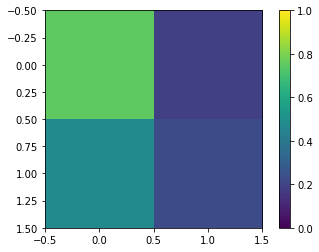

In [10]:
# Displaying Connection Probability Matrix (between cell types)
plt.imshow(conn_prob_matrix, cmap="viridis", vmin=0.0, vmax=1.0)
plt.colorbar()

#### -->Displaying Connection Probability Matrix (between all the different cells)

In [23]:
# Creating the Weight Matrix that will be plotted as a Heatmap
weight_matrix = np.zeros((5,5))
cellnames = [x.name for x in cells]

for nc in netcons:
    pre = nc.precell().name
    pos = nc.postcell().name
    ipre = cellnames.index(pre)
    ipos = cellnames.index(pos)
    weight_matrix[ipre,ipos] = nc.weight[0]
    

In [24]:
# Displaying Connection Probability Matrix (between all the different cells)

def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(5):
        for j in range(5):
            text = ax.text(j, i, "%.2f" %data[i, j],
                           ha="center", va="center", color="w")
    
    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title("Connectivity Matrix")
    
    
    return im, cbar

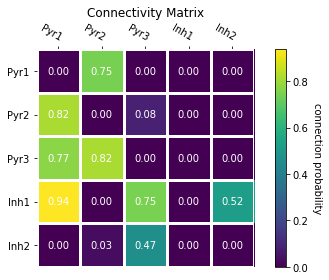

In [25]:
fig, ax = plt.subplots()

im, cbar = heatmap(weight_matrix, ['Pyr1', 'Pyr2', 'Pyr3', 'Inh1', 'Inh2'], ['Pyr1', 'Pyr2', 'Pyr3','Inh1', 'Inh2'], ax=ax, cmap="viridis", cbarlabel="connection probability")

fig.tight_layout()

### -->Number of contacts for each of our cell

In [27]:
## Printing the number of contacts each of our cell has:

print("In total, "+str(len(netcons))+' connections were made')

count_pyr1 = 0
count_pyr2 = 0
count_pyr3 = 0
count_inh1 = 0
count_inh2 = 0

for nc in netcons:
    pre = nc.precell().name
    ipre = cellnames.index(pre)
    if ipre == 0: # Pyramidal cell 1
        count_pyr1 += 1
    if ipre == 1: # Pyramidal cell 2
        count_pyr2 += 1
    if ipre == 2: # Pyramidal cell 3
        count_pyr3 += 1
    if ipre == 3: # Inhibitory cell 1
        count_inh1 += 1
    if ipre == 4: # Inhibitory cell 2
        count_inh2 += 1

print("Pyramidal cell 1 made "+str(count_pyr1)+" contacts")
print("Pyramidal cell 2 made "+str(count_pyr2)+" contacts")
print("Pyramidal cell 3 made "+str(count_pyr3)+" contacts")
print("Inhibitory cell 1 made "+str(count_inh1)+" contacts")
print("Inhibitory cell 2 made "+str(count_inh2)+" contacts")

In total, 10 connections were made
Pyramidal cell 1 made 1 contacts
Pyramidal cell 2 made 2 contacts
Pyramidal cell 3 made 2 contacts
Inhibitory cell 1 made 3 contacts
Inhibitory cell 2 made 2 contacts


# Ex3. Distribution of contacts: Convergence Matrix

<font size='3'>Considering the following mean contact points between cell types: 
<br> PC_axon - PC_basal: 3
<br> PC_axon - PC_apical: 1.5
<br> PC_axon - Inh_basal: 4
<br> Inh_axon - PC_soma: 3.5
<br> Inh_axon - PC_basal: 2.2
<br> Inh_axon - Inh_soma: 3.8
<br> Inh_axon - Inh_basal: 1.9

<font size='3'>Connect your cells by selecting the contact points from a normal distribution with a specific mean value per connection (values above). What is the maximum number of contacts you observe in your connectome ? Between which two cells ? Show the results on a __convergence__ matrix (how many contacts each of the cells receives from the others). [1.5 pts] 

<span style="color:red"> Restarting Kernel out of precaution...

### Step 1: Defining Cell Class

In [1]:
# Load usefull packages
%matplotlib inline

from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np
import math as m

In [2]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        h.load_file('import3d.hoc')
        h.load_file('stdlib.hoc')
        #morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self)
    
    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
        
        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        if hasattr(self, 'apic'):
            for sec in self.apic:
                sec.insert('hh')
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        for sec in self.dend:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
                
        for sec in self.axon:
            sec.insert('hh')
            for seg in sec:    
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

### Step 2: Instanciating the Cells from Homework 2

In [3]:
Pyr1 = Cell('morph_06.swc','Pyr1','Pyr')
Pyr2 = Cell('morph_07.swc','Pyr2','Pyr')
Pyr3 = Cell('morph_09.swc','Pyr3','Pyr')
Int1 = Cell('morph_03.swc','Int1','Int')
Int2 = Cell('morph_10.swc','Int2','Int')

# Classing the cells by group:
cells_Pyr = [Pyr1, Pyr2, Pyr3]
cells_Int = [Int1, Int2]
cells = cells_Pyr + cells_Int

error morph_06.swc line 17828: could not parse: 
error morph_07.swc line 19678: could not parse: 
error morph_09.swc line 6173: could not parse: 
error morph_03.swc line 7281: could not parse: 
error morph_10.swc line 3377: could not parse: 


In [4]:
for c in cells_Pyr:
    print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon)))
for c in cells_Int:
    print('%s: %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.dend), len(c.soma), len(c.axon)))

Pyr1: 95 apical sections, 72 basal sections, 2 soma sections and 131 axon senctions
Pyr2: 131 apical sections, 82 basal sections, 2 soma sections and 125 axon senctions
Pyr3: 37 apical sections, 69 basal sections, 2 soma sections and 67 axon senctions
Int1: 45 basal sections, 2 soma sections and 103 axon senctions
Int2: 33 basal sections, 2 soma sections and 120 axon senctions


### Step 3: Connecting Cells by selecting contact point distribution

In [5]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(source, target, weight = None, delay = 5, source_sec = None, source_neurite = 'axon', target_sec = None, target_neurite = 'dend'):
    rng = np.random.default_rng()
    
    if weight is None:
        weight = rng.uniform() # random weight
    
    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0,len(target_neurite_)) # random dendritic section
    
    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0,len(source_neurite_)) # random axonal section
    
    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn) # store synapse
    
    netcon = h.NetCon(source_neurite_[source_sec](0.5)._ref_v, target_syn, sec=source_neurite_[source_sec])
    netcon.weight[0] = weight
    netcon.delay = delay
    
    print('Connected cells %s -> %s with weight %g and delay %g, from %s[%d] to %s[%d]' % (source.name,target.name,weight,delay,source_neurite,source_sec,target_neurite,target_sec))
    return netcon

In [6]:
# specify connection probabilites between cell types
conn_prob_matrix = np.zeros((2,2))
conn_prob_matrix[0,0] = 0.75 # Pyr to Pyr
conn_prob_matrix[0,1] = 0.19 # Pyr to Int
conn_prob_matrix[1,0] = 0.48 # Int to Pyr
conn_prob_matrix[1,1] = 0.23 # Int to Int

In [8]:
# specify expected number of contacts between cell types, considering target neurite
expected_contacts = np.zeros((2,2,3), dtype=int)

expected_contacts[0,0,0] = 0 # Pyr to Pyr (soma)
expected_contacts[0,0,1] = 3 # Pyr to Pyr (dend)
expected_contacts[0,0,2] = 1.5 # Pyr to Pyr (apic)

expected_contacts[1,0,0] = 3.5 # Int to Pyr (soma)
expected_contacts[1,0,1] = 2.2 # Int to Pyr (dend)
expected_contacts[1,0,2] = 0 # Int to Pyr (apic)

expected_contacts[0,1,0] = 0 # Pyr to Int (soma)
expected_contacts[0,1,1] = 4 # Pyr to Int (dend)

expected_contacts[1,1,0] = 3.8 # Int to Int (soma)
expected_contacts[1,1,1] = 1.9 # Int to Int (dend)

In [9]:
# generate number of contacts per cell type, by selecting them from a normal distribution 
# in which the mean is the expected_contacts value

netcons = [] # store all netcons

rng = np.random.default_rng()

############ Pyramidal 1
# Connect Pyr2 to Pyr1
if rng.random() < conn_prob_matrix[0,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[0,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr2, Pyr1, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr3 to Pyr1
if rng.random() < conn_prob_matrix[0,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[0,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr3, Pyr1, target_neurite=neurite)
            netcons.append(nc)

# Connect Int1 to Pyr1
if rng.random() < conn_prob_matrix[1,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[1,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Int1, Pyr1, target_neurite=neurite)
            netcons.append(nc)
            
# Connect Int2 to Pyr1
if rng.random() < conn_prob_matrix[1,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[1,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Int2, Pyr1, target_neurite=neurite)
            netcons.append(nc)

############ Pyramidal 2
# Connect Pyr1 to Pyr2
if rng.random() < conn_prob_matrix[0,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[0,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr1, Pyr2, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr3 to Pyr2
if rng.random() < conn_prob_matrix[0,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[0,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr3, Pyr2, target_neurite=neurite)
            netcons.append(nc)

# Connect Int1 to Pyr2
if rng.random() < conn_prob_matrix[1,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[1,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Int1, Pyr2, target_neurite=neurite)
            netcons.append(nc)
            
# Connect Int2 to Pyr2
if rng.random() < conn_prob_matrix[1,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[1,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Int2, Pyr2, target_neurite=neurite)
            netcons.append(nc)

############ Pyramidal 3
# Connect Pyr1 to Pyr3
if rng.random() < conn_prob_matrix[0,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[0,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr1, Pyr3, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr2 to Pyr3
if rng.random() < conn_prob_matrix[0,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[0,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr2, Pyr3, target_neurite=neurite)
            netcons.append(nc)

# Connect Int1 to Pyr3
if rng.random() < conn_prob_matrix[1,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[1,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Int1, Pyr3, target_neurite=neurite)
            netcons.append(nc)
            
# Connect Int2 to Pyr3
if rng.random() < conn_prob_matrix[1,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[1,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Int2, Pyr3, target_neurite=neurite)
            netcons.append(nc)

############ Inhibitory 1
# Connect Pyr1 to Int1
if rng.random() < conn_prob_matrix[0,1]:
    for i,neurite in enumerate(['soma','dend']):
        contacts = expected_contacts[0,1,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr1, Int1, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr2 to Int1
if rng.random() < conn_prob_matrix[0,1]:
    for i,neurite in enumerate(['soma','dend']):
        contacts = expected_contacts[0,1,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr2, Int1, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr3 to Int1
if rng.random() < conn_prob_matrix[0,1]:
    for i,neurite in enumerate(['soma','dend']):
        contacts = expected_contacts[0,1,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr3, Int1, target_neurite=neurite)
            netcons.append(nc)

# Connect Int2 to Int1
if rng.random() < conn_prob_matrix[1,1]:
    for i,neurite in enumerate(['soma','dend']):
        contacts = expected_contacts[1,1,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Int2, Int1, target_neurite=neurite)
            netcons.append(nc)

############ Inhibitory 2
# Connect Pyr1 to Int2
if rng.random() < conn_prob_matrix[0,1]:
    for i,neurite in enumerate(['soma','dend']):
        contacts = expected_contacts[0,1,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr1, Int2, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr2 to Int2
if rng.random() < conn_prob_matrix[0,1]:
    for i,neurite in enumerate(['soma','dend']):
        contacts = expected_contacts[0,1,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr2, Int2, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr3 to Int2
if rng.random() < conn_prob_matrix[0,1]:
    for i,neurite in enumerate(['soma','dend']):
        contacts = expected_contacts[0,1,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr3, Int2, target_neurite=neurite)
            netcons.append(nc)

# Connect Int1 to Int2
if rng.random() < conn_prob_matrix[1,1]:
    for i,neurite in enumerate(['soma','dend']):
        contacts = expected_contacts[1,1,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Int1, Int2, target_neurite=neurite)
            netcons.append(nc)

Connected cells Int1 -> Pyr1 with weight 0.689197 and delay 5, from axon[26] to soma[1]
Connected cells Int1 -> Pyr1 with weight 0.603507 and delay 5, from axon[64] to soma[1]
Connected cells Int1 -> Pyr1 with weight 0.565734 and delay 5, from axon[33] to soma[1]
Connected cells Pyr1 -> Pyr2 with weight 0.0623651 and delay 5, from axon[126] to dend[7]
Connected cells Pyr1 -> Pyr2 with weight 0.355298 and delay 5, from axon[103] to dend[79]
Connected cells Pyr1 -> Pyr2 with weight 0.315569 and delay 5, from axon[110] to apic[89]
Connected cells Pyr1 -> Pyr2 with weight 0.306294 and delay 5, from axon[58] to apic[24]
Connected cells Int2 -> Pyr2 with weight 0.102874 and delay 5, from axon[8] to soma[1]
Connected cells Int2 -> Pyr2 with weight 0.531291 and delay 5, from axon[22] to soma[0]
Connected cells Int2 -> Pyr2 with weight 0.0621575 and delay 5, from axon[56] to soma[0]
Connected cells Int2 -> Pyr2 with weight 0.729268 and delay 5, from axon[34] to dend[68]
Connected cells Int2 -> 

In [13]:
len(netcons)

23

### What is the maximum number of contacts you observe in your connectome ? Between which two cells ? Show the results on a convergence matrix (how many contacts each of the cells receives from the others).

#### --> Computing maximum number of contacts:

In [38]:
cellnames = [x.name for x in cells]

pyr_1_contacts = np.zeros((1,5))
pyr_2_contacts = np.zeros((1,5))
pyr_3_contacts = np.zeros((1,5))
int_1_contacts = np.zeros((1,5))
int_2_contacts = np.zeros((1,5))

# iterate over netcons and count
for nc in netcons:
    pre = nc.precell().name
    pos = nc.postcell().name
    ipre = cellnames.index(pre)
    ipos = cellnames.index(pos)
    if ipre == 0:
        pyr_1_contacts[0][ipos] += 1
    if ipre == 1:
        pyr_2_contacts[0][ipos] += 1
    if ipre == 2:
        pyr_3_contacts[0][ipos] += 1
    if ipre == 3:
        int_1_contacts[0][ipos] += 1
    if ipre == 4:
        int_2_contacts[0][ipos] += 1


print("For pyramidal cell 1, it made at most "+str(int(np.max(pyr_1_contacts)))+' with '+str(cellnames[np.argmax(pyr_1_contacts)]))
print("For pyramidal cell 2, it made at most "+str(int(np.max(pyr_2_contacts)))+' with '+str(cellnames[np.argmax(pyr_2_contacts)]))
print("For pyramidal cell 3, it made at most "+str(int(np.max(pyr_3_contacts)))+' with '+str(cellnames[np.argmax(pyr_3_contacts)]))
print("For inhibitory cell 1, it made at most "+str(int(np.max(int_1_contacts)))+' with '+str(cellnames[np.argmax(int_1_contacts)]))
print("For inhibitory cell 2, it made at most "+str(int(np.max(int_2_contacts)))+' with '+str(cellnames[np.argmax(int_2_contacts)]))

For pyramidal cell 1, it made at most 4 with Pyr2
For pyramidal cell 2, it made at most 0 with Pyr1
For pyramidal cell 3, it made at most 3 with Int1
For inhibitory cell 1, it made at most 3 with Pyr1
For inhibitory cell 2, it made at most 5 with Pyr2


In this particular connectome, we can deduce that the maximal number of contacts made was 5, and it was between inhibitory cell 2 and pyramidal cell 2.

#### --> Computing maximum number of contacts:

In [47]:
# Convergence Matrix:

convergence_matrix = np.zeros((5,5))
cellnames = [x.name for x in cells]

# iterate over netcons and count
for nc in netcons:
    pre = nc.precell().name
    pos = nc.postcell().name
    ipre = cellnames.index(pre)
    ipos = cellnames.index(pos)
    convergence_matrix[ipos,ipre] += 1 

In [48]:
# Displaying Connection Probability Matrix (between all the different cells)

def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(5):
        for j in range(5):
            text = ax.text(j, i, "%.0f" %data[i, j],
                           ha="center", va="center", color="w")
    
    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title("Convergence Matrix")
    
    
    return im, cbar

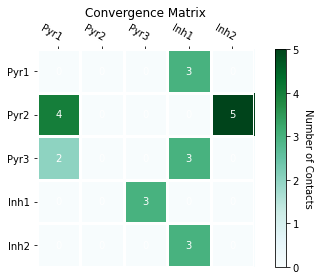

In [55]:
fig, ax = plt.subplots()

im, cbar = heatmap(convergence_matrix, ['Pyr1', 'Pyr2', 'Pyr3', 'Inh1', 'Inh2'], ['Pyr1', 'Pyr2', 'Pyr3','Inh1', 'Inh2'], ax=ax, cmap="BuGn", cbarlabel="Number of Contacts")

fig.tight_layout()

# Ex4. Real Connectivity Rules

<font size='3'>Read the articles uploaded on the HomeWork folder (Markram_1997.pdf and Gupta_2000.pdf). 

<font size='3'>Imaging that you have to build a network with your five cells (3 pyramidals and 2 GABAergic interneurons) from rat somatosensory cortex. Extract from the papers the data that you would need to connect your cells (connectivity rules). Enumerate the data chosen to connect your cells. Using and modifying (if needed) the code from the tutorials, connect your five cells in a more biological way using the connectivity rules found in the papers. [2.5 pts]

#### Connectivity rules for the Pyramidal Excitatory Cells: (Markram 1997):

According to the paper:

- For both unidirectional and bidirectional:
    - the synaptic connections between pairs of pyramidal neurons 70% were unidirectional and 30% were bidirectional
    - Probability of finding a synaptic correction in dual recordings was: 0.1% (but this could be higher if no artefacts introduced with to the brain slices)
    - number of potential synaptic contacts formed by a presynaptic neuron on a target neuron varied between 4 and 8 (mean 5.5 contacts)
    - synaptic contacts were preferenteially located on basal dendrites (63%), and apical oblique dendrites (27%) and 35% of all contacts were located on tertiatry basal dendritic branches
    
- For unidirectional synaptic connections:
   - five or more contacts were established with the target neuron and these contacts were found on the entire dendritic tree
   - 58% of all potential synaptic contacts identified were located on basal dendrites (of these, 91% were located on secondary and tertiary dendritic branches), and tertiary dendritic branches are at a distance of 60-100 µm from the soma
   
   
- For bidirectional synaptic connections:
    - mean number of potential synaptic connections on target neurons is 5.5
    - distribution of synaptic contacts was also similar to that found on target neurons of unidirectional pairs
    - of all potential synaptic contacts identified: (66.7%) was located on basal dendrites

#### Connectivity rules for the Inhibitory Interneuron Cells: (Gupta 2000):

According to this paper:

- 800 quadruple recordings, yielding 3000 potential GABAergic connections, and there were more than 240 GABAergic connections: the connection probability can be deduced as 240/3000
- 